# Walmart - Store Sales Forecasting

For this Machine Learning project, we will use the “Walmart Recruiting - Store Sales Forecasting” dataset, from Kaggle.

The goal is to predict the Weekly Sales for specific stores, departments and dates.

# Download Data

First, we install the opendatasets library.

In [1]:
pip install opendatasets --upgrade

     |████████████████████████████████| 58 kB 4.8 MB/s eta 0:00:011
     |████████████████████████████████| 78 kB 6.7 MB/s  eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=dd4304085b0006cc5664f8c02d94d7c54a480af025e40f5521209280e0c17b9a
  Stored in directory: /home/jovyan/.cache/pip/wheels/ac/b2/c3/fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle
Note: you may need to restart the kernel to use updated packages.


Now we import some libraries that we will use

In [2]:
import opendatasets as od
import os
from zipfile import ZipFile

import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt

Here we download the datasets from Kaggle

In [4]:
dataset_url = 'https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting'
od.download('https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting')

Skipping, found downloaded files in "./walmart-recruiting-store-sales-forecasting" (use force=True to force download)


Let's review the downloaded files.

In [5]:
os.listdir('walmart-recruiting-store-sales-forecasting')

['test.csv.zip',
 'train.csv.zip',
 'stores.csv',
 'features.csv.zip',
 'sampleSubmission.csv.zip']

**1. stores.csv:** This file contains anonymized information about the 45 stores, indicating the type and size of store.


**2. train.csv:** This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file we will find the following fields:
- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week

**3. test.csv:** This file is identical to train.csv, except we have withheld the weekly sales. We must predict the sales for each triplet of store, department, and date in this file.


**4. features.csv:** This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:
- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week

Now, we get the zip files and create the datasets that we will use

In [6]:
train_zip_file = ZipFile('walmart-recruiting-store-sales-forecasting/train.csv.zip')
features_zip_file = ZipFile('walmart-recruiting-store-sales-forecasting/features.csv.zip')
test_zip_file = ZipFile('walmart-recruiting-store-sales-forecasting/test.csv.zip')
sample_submission_zip_file = ZipFile('walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip')

In [7]:
train_df = pd.read_csv(train_zip_file.open('train.csv'))
features_df = pd.read_csv(features_zip_file.open('features.csv'))
stores_df = pd.read_csv('walmart-recruiting-store-sales-forecasting/stores.csv')
test_df = pd.read_csv(test_zip_file.open('test.csv'))
submission_df = pd.read_csv(sample_submission_zip_file.open('sampleSubmission.csv'))

Before starting to work with the data, we can merge the files train, stores and features, in order to increase the number of input variables.

In [8]:
dataset = train_df.merge(stores_df, how='left').merge(features_df, how='left')
test_dataset = test_df.merge(stores_df, how='left').merge(features_df, how='left')

# Data exploration

Let's have a look of our dataset

In [9]:
dataset.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


We can identify the following input variables:

* Store
* Dept
* Date
* IsHoliday
* Type
* Size
* Temperature
* Fuel_Price
* MarkDown1
* MarkDown2
* MarkDown3
* MarkDown4
* MarkDown5
* CPI
* Unemployment

The Target variable is Weekly_Sales

Now let's review some measures of central tendency.

In [10]:
dataset.describe(include = 'all')

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570,421570.000000,421570,421570,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
unique,NaN,NaN,143,NaN,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2011-12-23,NaN,False,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,3027,NaN,391909,215478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,22.200546,44.260317,NaN,15981.258123,NaN,NaN,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,NaN,22711.183519,NaN,NaN,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,NaN,-4988.940000,NaN,NaN,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,NaN,2079.650000,NaN,NaN,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,NaN,7612.030000,NaN,NaN,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,NaN,20205.852500,NaN,NaN,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000


## Null Values

There are some null values, let's review them

In [11]:
# Checking the NaN percentage
dataset.isnull().mean() * 100

Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday        0.000000
Type             0.000000
Size             0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
dtype: float64

We will drop the null values in the Data Manipulation section.

## Input Variables Correlation with the output feature Weekly_Sales

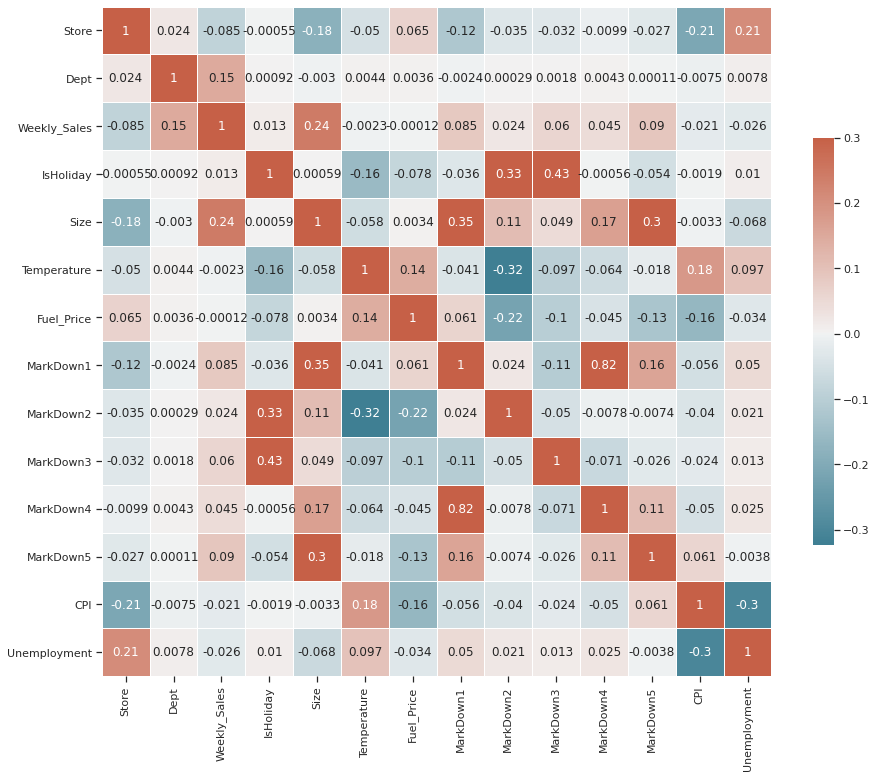

In [12]:
corr = dataset.corr()
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

By watching the correlation matrix, we can see that Weekly_Sales have a higher correlation with Store, Dept and Size.

We will drop the variables with lower correlation in the Data Manipulation section.

# Data Manipulation

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

Now, we will do the following steps:
* Remove null values from the markdown variables.
* Create variables for year, month and week, based on the date field.
* Remove the variables with low correlation.

In [14]:
dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
dataset['Year'] = pd.to_datetime(dataset['Date']).dt.year
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month
dataset['Week'] = pd.to_datetime(dataset['Date']).dt.isocalendar().week
dataset = dataset.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'Temperature'])

We can move the target variable to the last column of the dataframe to ease the manipulation of the data.

In [15]:
df = dataset.pop('Weekly_Sales')
dataset['Weekly_Sales'] = df

Here, we identify inputs and target columns.

In [16]:
input_cols, target_col = dataset.columns[:-1], dataset.columns[-1]
inputs_df, targets = dataset[input_cols].copy(), dataset[target_col].copy()

Now, we identify numeric and categorical columns.

In [17]:
numeric_cols = dataset[input_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = dataset[input_cols].select_dtypes(include='object').columns.tolist()

Here, we impute (fill) and scale numeric columns.

In [18]:
imputer = SimpleImputer().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = imputer.transform(inputs_df[numeric_cols])
scaler = MinMaxScaler().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = scaler.transform(inputs_df[numeric_cols])

We can only use numeric data to train our models, that's why we have to use a technique called "one-hot encoding" for our categorical columns.

One hot encoding involves adding a new binary (0/1) column for each unique category of a categorical column.

In [19]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))
inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])

Finally, let's split the dataset into a training and validation set. We'll use a randomly select 25% subset of the data for validation. Also, we'll use just the numeric and encoded columns, since the inputs to our model must be numbers.

In [20]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df[numeric_cols + encoded_cols], targets, test_size=0.25, random_state=42)

# Models

Now that we have our training and validation set, we will review two models of machine learning:

* Decision Tree
* Random Forest

Based on the results, we will pick one of them.

## Decision Tree

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

To create our decision tree model, we can use the function DecisionTreeRegressor.

In [21]:
from sklearn.tree import DecisionTreeRegressor

In [22]:
tree = DecisionTreeRegressor(random_state=0)

Now, we fit our model to the training data.

In [23]:
%%time
tree.fit(train_inputs, train_targets)

CPU times: user 2.17 s, sys: 26.8 ms, total: 2.2 s
Wall time: 2.19 s


DecisionTreeRegressor(random_state=0)

We generate predictions on the training and validation sets using the trained decision tree, and compute the Root Mean Squared Error (RMSE) loss.

In [24]:
from sklearn.metrics import mean_squared_error

In [25]:
tree_train_preds = tree.predict(train_inputs)

In [26]:
tree_train_rmse = mean_squared_error(train_targets, tree_train_preds, squared=False)

In [27]:
tree_val_preds = tree.predict(val_inputs)

In [28]:
tree_val_rmse = mean_squared_error(val_targets, tree_val_preds, squared=False)

In [29]:
print('Train RMSE: {}, Validation RMSE: {}'.format(tree_train_rmse, tree_val_rmse))

Train RMSE: 6.045479193458183e-20, Validation RMSE: 5441.340994336662


Here, we can see that the RMSE loss for our train data is 6.045479193458183e-20, and the RMSE loss for our validation data is 5441.340994336662

### Decision tree visualization

In [30]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

Let's visualize the tree graphically using plot_tree.

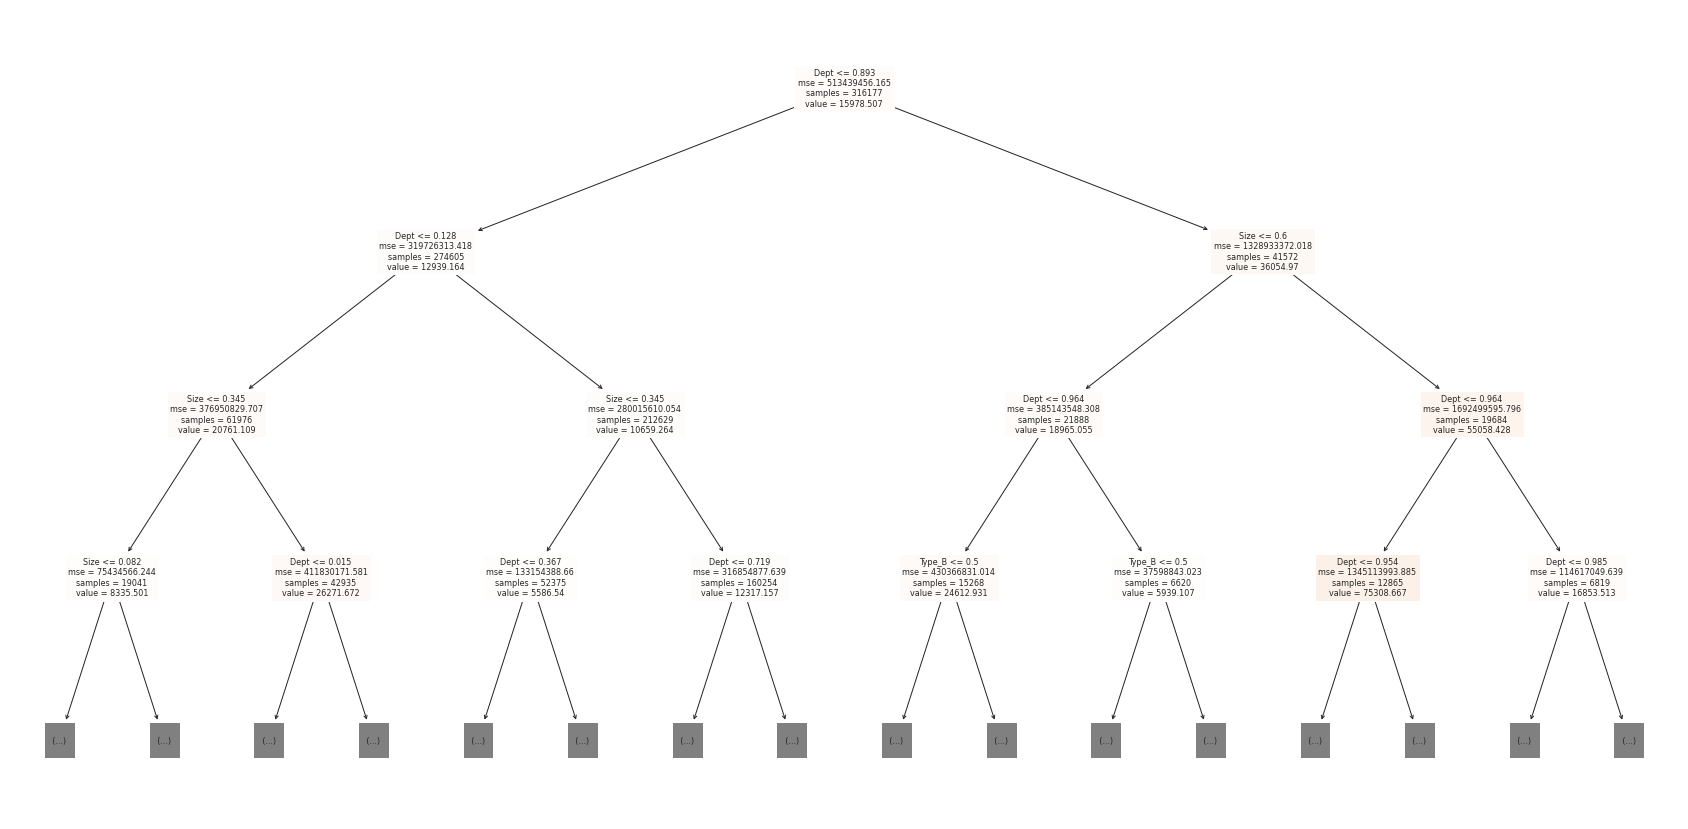

In [31]:
plt.figure(figsize=(30,15))
plot_tree(tree, feature_names=train_inputs.columns, max_depth=3, filled=True);

Now, let Visualize the tree textually using export_text.

In [32]:
tree_text = export_text(tree, feature_names=list(train_inputs.columns))

Here we can display the first few lines.

In [33]:
print(tree_text[:2000])

|--- Dept <= 0.89
|   |--- Dept <= 0.13
|   |   |--- Size <= 0.35
|   |   |   |--- Size <= 0.08
|   |   |   |   |--- Dept <= 0.02
|   |   |   |   |   |--- Dept <= 0.01
|   |   |   |   |   |   |--- Type_A <= 0.50
|   |   |   |   |   |   |   |--- Week <= 0.75
|   |   |   |   |   |   |   |   |--- Week <= 0.32
|   |   |   |   |   |   |   |   |   |--- MarkDown5 <= 0.01
|   |   |   |   |   |   |   |   |   |   |--- Store <= 0.94
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 14
|   |   |   |   |   |   |   |   |   |   |--- Store >  0.94
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |   |   |   |   |--- MarkDown5 >  0.01
|   |   |   |   |   |   |   |   |   |   |--- MarkDown5 <= 0.01
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |   |--- MarkDown5 >  0.01
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 14
|   |   |   |   |  

### Decision Tree feature importance

Let's look at the weights assigned to different columns, to figure out which columns in the dataset are the most important.

In [34]:
tree_importances = tree.feature_importances_

In [35]:
tree_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_importances
}).sort_values('importance', ascending=False)

In [36]:
tree_importance_df

,feature,importance
1,Dept,0.636039
2,Size,0.198802
0,Store,0.072103
10,Week,0.055737
12,Type_B,0.013551
5,MarkDown3,0.004337
9,Month,0.003614
8,Year,0.003393
6,MarkDown4,0.003347
11,Type_A,0.003196


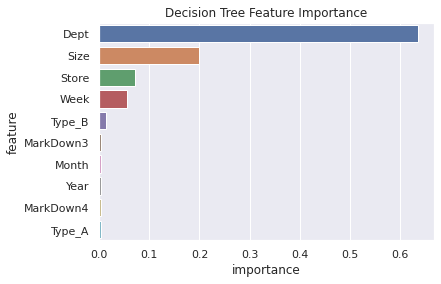

In [37]:
plt.title('Decision Tree Feature Importance')
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature');

The variables Dept, Size, Store and Week are the most important for this model.

## Random Forests

Random forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time.

For classification tasks, the output of the random forest is the class selected by most trees. 

For regression tasks, the mean or average prediction of the individual trees is returned.

To create our random forest model, we can use the function RandomForestRegressor.

In [38]:
from sklearn.ensemble import RandomForestRegressor

When I created the random forest with the default number of estimators (100), the jupyter notebook crashed due to a lack of memory, so let's start with a number of estimators of 10.

In [39]:
rf1 = RandomForestRegressor(random_state=0, n_estimators=10)

Now, we fit our model to the training data.

In [40]:
%%time
rf1.fit(train_inputs, train_targets)

CPU times: user 13.1 s, sys: 112 ms, total: 13.2 s
Wall time: 13.2 s


RandomForestRegressor(n_estimators=10, random_state=0)

Now we generate predictions on the training and validation sets using the trained random forest, and compute the Root Mean Squared Error (RMSE) loss.

In [41]:
rf1_train_preds = rf1.predict(train_inputs)

In [42]:
rf1_train_rmse = mean_squared_error(train_targets, rf1_train_preds, squared=False)

In [43]:
rf1_val_preds = rf1.predict(val_inputs)

In [44]:
rf1_val_rmse = mean_squared_error(val_targets, rf1_val_preds, squared=False)

In [45]:
print('Train RMSE: {}, Validation RMSE: {}'.format(rf1_train_rmse, rf1_val_rmse))

Train RMSE: 1620.993367981347, Validation RMSE: 3997.6712441772224


Here, we can see that the RMSE loss for our train data is 1620.993367981347, and the RMSE loss for our validation data is 3997.6712441772224

The random forest model shows better results for the validation RMSE, so we will use that model.

# Hyperparameter Tuning

Let's define a helper function test_params which can test the given value of one or more hyperparameters.

For this new random forest model, I will use a number of estimators of 16.

In [46]:
def test_params(**params):
    model = RandomForestRegressor(random_state=0, n_jobs=-1, n_estimators=16, **params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

Let's also define a helper function to test and plot different values of a single parameter.

In [47]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [48]:
test_params()

(1538.6031204571725, 3946.105075819126)

We can see better results with a higher number of estimators.

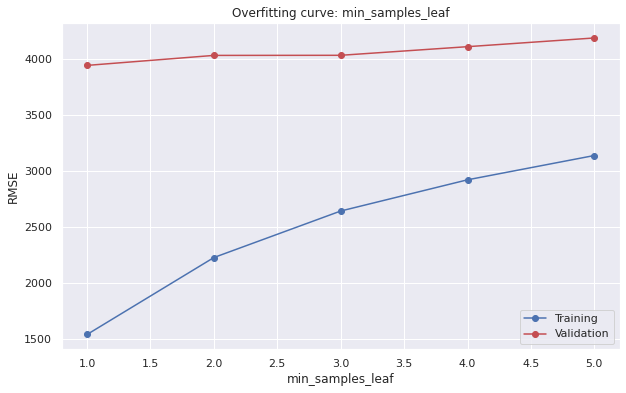

In [49]:
test_param_and_plot('min_samples_leaf', [1, 2, 3, 4, 5])

In [50]:
test_params(min_samples_leaf = 5)

(3139.860605280673, 4191.528032848276)

Here, we can see how the RMSE increases with the min_samples_leaf parameter, so we will use the default value (1).

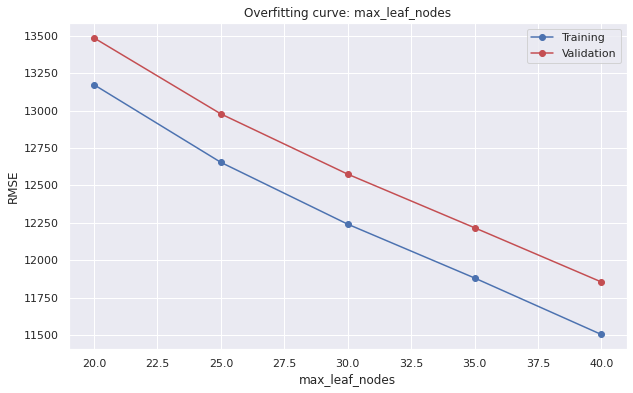

In [51]:
test_param_and_plot('max_leaf_nodes', [20, 25, 30, 35, 40])

In [52]:
test_params(max_leaf_nodes = 20)

(13172.46592071017, 13485.14172240374)

The RMSE decreases with the max_leaf_nodes parameter, so we will use the default value (none).

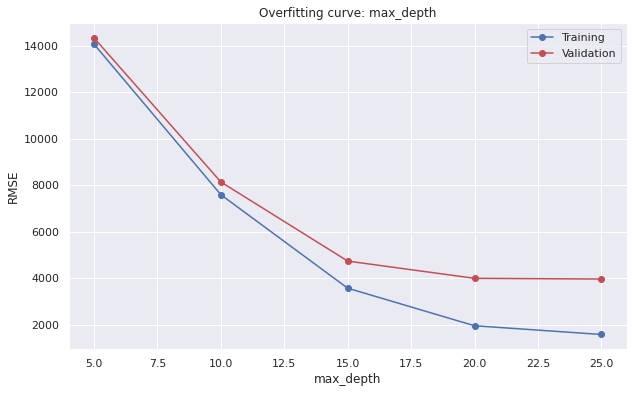

In [53]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25])

In [54]:
test_params(max_depth = 10)

(7597.643155388232, 8145.895516784769)

The RMSE decreases with the max_depth parameter, so we will use the default value (none).

# Training the Best Model

We create a new Random Forest model with custom hyperparameters.

In [55]:
rf2 = RandomForestRegressor(n_estimators=16, random_state = 0, min_samples_leaf = 1)

Now we train the model.

In [56]:
rf2.fit(train_inputs, train_targets)

RandomForestRegressor(n_estimators=16, random_state=0)

Now we generate predictions for the final model.

In [57]:
rf2_train_preds = rf2.predict(train_inputs)

In [58]:
rf2_train_rmse = mean_squared_error(train_targets, rf2_train_preds, squared=False)

In [59]:
rf2_val_preds = rf2.predict(val_inputs)

In [60]:
rf2_val_rmse = mean_squared_error(val_targets, rf2_val_preds, squared=False)

In [61]:
print('Train RMSE: {}, Validation RMSE: {}'.format(rf2_train_rmse, rf2_val_rmse))

Train RMSE: 1538.6031204571725, Validation RMSE: 3946.105075819126


Here, we can see a decrease for the RMSE loss.

# Random Forest Feature Importance

Let's look at the weights assigned to different columns, to figure out which columns in the dataset are the most important for this model.

In [62]:
rf2_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': rf2.feature_importances_
}).sort_values('importance', ascending=False)

In [63]:
rf2_importance_df

,feature,importance
1,Dept,0.627801
2,Size,0.205967
0,Store,0.073425
10,Week,0.050421
12,Type_B,0.011083
5,MarkDown3,0.007831
9,Month,0.007729
8,Year,0.003370
11,Type_A,0.002985
6,MarkDown4,0.002700


<AxesSubplot:xlabel='importance', ylabel='feature'>

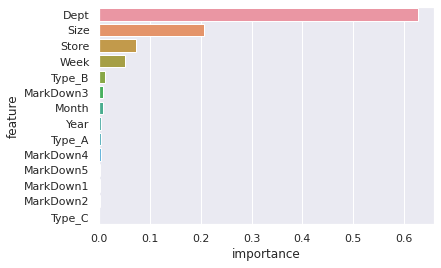

In [64]:
sns.barplot(data=rf2_importance_df, x='importance', y='feature')

The variables Dept, Size, Store and Week are the most important for this model.

# Making Predictions on the Test Set

Let's make predictions on the test set provided with the data.

First, we need to reapply all the preprocessing steps.

In [65]:
test_dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = test_dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
test_dataset['Year'] = pd.to_datetime(test_dataset['Date']).dt.year
test_dataset['Month'] = pd.to_datetime(test_dataset['Date']).dt.month
test_dataset['Week'] = pd.to_datetime(test_dataset['Date']).dt.isocalendar().week
test_dataset = test_dataset.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'Temperature'])

In [66]:
test_dataset

,Store,Dept,IsHoliday,Type,Size,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Year,Month,Week
0,1,1,False,A,151315,6766.44,5147.70,50.82,3639.90,2737.42,2012,11,44
1,1,1,False,A,151315,11421.32,3370.89,40.28,4646.79,6154.16,2012,11,45
2,1,1,False,A,151315,9696.28,292.10,103.78,1133.15,6612.69,2012,11,46
3,1,1,True,A,151315,883.59,4.17,74910.32,209.91,303.32,2012,11,47
4,1,1,False,A,151315,2460.03,0.00,3838.35,150.57,6966.34,2012,11,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,False,B,118221,4842.29,975.03,3.00,2449.97,3169.69,2013,6,26
115060,45,98,False,B,118221,9090.48,2268.58,582.74,5797.47,1514.93,2013,7,27
115061,45,98,False,B,118221,3789.94,1827.31,85.72,744.84,2150.36,2013,7,28
115062,45,98,False,B,118221,2961.49,1047.07,204.19,363.00,1059.46,2013,7,29


In [67]:
test_dataset[numeric_cols] = imputer.transform(test_dataset[numeric_cols])
test_dataset[numeric_cols] = scaler.transform(test_dataset[numeric_cols])
test_dataset[encoded_cols] = encoder.transform(test_dataset[categorical_cols])

In [68]:
test_inputs = test_dataset[numeric_cols + encoded_cols]

We can now make predictions using our final model.

In [69]:
test_preds = rf2.predict(test_inputs)

Let's replace the values of the Weekly_Sales column with our predictions.

In [70]:
submission_df['Weekly_Sales'] = test_preds

Let's save it as a CSV file and download it.

In [71]:
submission_df.to_csv('submission.csv', index=False)

In [72]:
from IPython.display import FileLink
FileLink('submission.csv') # Doesn't work on Colab, use the file browser instead to download the file.

/home/jovyan/submission.csv

# Making Predictions on Single Inputs

In [73]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols].values)
    return model.predict(input_df[numeric_cols + encoded_cols])[0]

In [74]:
sample_input = {'Store':9, 'Dept':72, 'IsHoliday':True, 'Type':'B', 'Size':125833, 'MarkDown1':2.5, 'MarkDown2':0.02, 
                'MarkDown3':55952.99, 'MarkDown4':14.64, 'MarkDown5':310.72, 'Year':2012, 'Month':11, 'Week':47}

In [75]:
predicted_price = predict_input(rf2, sample_input)

In [76]:
print('The predicted weekly sales is ${}'.format(predicted_price))

The predicted weekly sales is $475908.2475000001


# Saving the Model

In [77]:
import joblib

In [78]:
walmart_sales_rf = {
    'model': rf2,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [79]:
joblib.dump(walmart_sales_rf, 'walmart_sales_rf.joblib')

['walmart_sales_rf.joblib']

# Save the Project

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="walmart-store-sales-forecasting")

<IPython.core.display.Javascript object>

# References

Check out the following resources to learn more:
* Walmart - Store Sales Forecasting: https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting
* Scikit-learn documentation: https://scikit-learn.org/stable/index.html
* Scikit-learn DecisionTreeRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
* Scikit-learn RandomForestRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
* Pandas: https://pandas.pydata.org/docs/user_guide/index.html
* TP2 - Walmart Sales Forecast: https://www.kaggle.com/andredornas/tp2-walmart-sales-forecast
* Walmart - Store Sales Forecasting: https://www.kaggle.com/avelinocaio/walmart-store-sales-forecasting
